In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import pickle
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
from sklearn.preprocessing import Normalizer
from get_dataset import datasets
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression

sys.path.append("..")
sys.path.append("../analyze")
sys.path.append("../measuring_volume")
sys.path.append("../common")
import pickle
from classify_seq import make_input_seq as mis

import keras_tuner as kt

type_of_l = "L2"

In [2]:
pwd

'/Users/hyakuzukamaya/Desktop/lab/judgement_system/script/analyze'

## Loading a dataset

## Split into train data and test data as dataset
- データセットとして使用するデータを取得する。
- trainデータとtestデータに分割する。（例えば80%をtrainデータに、20%をtestデータに、など。）
- 書き方はデータセットとして使用するデータの type による。もし、numpy の形で持っているならhttps://www.tensorflow.org/tutorials/load_data/numpy?hl=ja が参考になります。

データセットからx, yを作成する

In [3]:
# [0, 1, ... 0] + temperature + eigenvalue
f1 = open("../../data/dic/x_initial_L2.pkl", "rb")
f2 = open("../../data/dic/L2_data_initial.pkl", "rb")
domain_seq_dic = pickle.load(f1)
value_dic = pickle.load(f2)
domain_lst = mis.seq_lst(f"../../input/input_seq_{type_of_l}.csv")

f1.close()
f2.close()

x_data = []
y_data = []

for key in domain_seq_dic:
    new_x = []
    for domain in domain_lst:
        new_x.append(domain_seq_dic[key]["domain"][domain])
    new_x.append(int(key[0]))
    new_x.append(float(domain_seq_dic[key]['eigenValue_2']))
    x_data.append(new_x)
    y_data.append(value_dic[key]['mean_volume'])

print(x_data)
print(y_data)



[[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 338, 0.913542552403261], [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [4]:
x_data = np.array(x_data)
y_data = np.array(y_data)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)


## Set my model
- input_shape は入力データのサイズ。
- モデルの定義方法は調べればたくさん出てきますが、例えばここ： https://sinyblog.com/deaplearning/keras_how_to/ 
- 最後の層の出力は、期待する出力データのサイズ
- [model](https://github.com/si-tm/docs-L20n/blob/master/site/ja/tutorials/quickstart/beginner.py)

In [5]:
def build_model():
    
    # model = tf.keras.models.Sequential([
    # tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    # tf.keras.layers.Dense(128, activation='relu'), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    # tf.keras.layers.Dense(1) 
    # ])

    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', name="layer1"), # units=128 : 出力空間の次元数
    tf.keras.layers.Dense(128, activation='relu', name="layer2"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer3"), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer4"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer5"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    tf.keras.layers.Dense(1) 
    ])

    optimizer = tf.keras.optimizers.Adam() # optimizers も Adam 以外に色々種類があります。調べてみてください！

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # loss 関数に何を採用するかはどんな問題を解きたいのかによります。
                                        #ここでは MSE を採用していますが、他にも色々な選択肢があります。調べてみてください！
    return model

In [6]:
model = build_model()

2024-03-26 19:29:42.157871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 258)               0         
                                                                 
 layer1 (Dense)              (None, 128)               33152     
                                                                 
 layer2 (Dense)              (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 49,793
Trainable params: 49,793
Non-trainable params: 0
_________________________________________________________________


In [8]:
example_batch = x_train[:10]
print(example_batch.shape)
example_result = model.predict(example_batch)
# example_result

(10, 258)
1/1 [==============================] - 0s 65ms/step


In [9]:
print(example_result)

[[-13.202273 ]
 [-14.4403305]
 [-14.883543 ]
 [-15.860394 ]
 [-14.895659 ]
 [-15.878907 ]
 [-15.771032 ]
 [-13.058514 ]
 [-15.327385 ]
 [-14.907862 ]]


In [10]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 100 # epoch 数も考慮しよう
# EPOCHS = 100 # epoch 数も考慮しよう

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,8.835932,1.795692,8.835932,2.081913,1.195216,2.081913,95
96,8.057654,1.825544,8.057654,2.530987,1.378837,2.530987,96
97,7.947452,1.949934,7.947452,2.528949,1.378915,2.528949,97
98,7.953803,1.805348,7.953803,2.137175,1.048136,2.137175,98
99,8.617249,1.774518,8.617249,2.486907,1.366072,2.486907,99


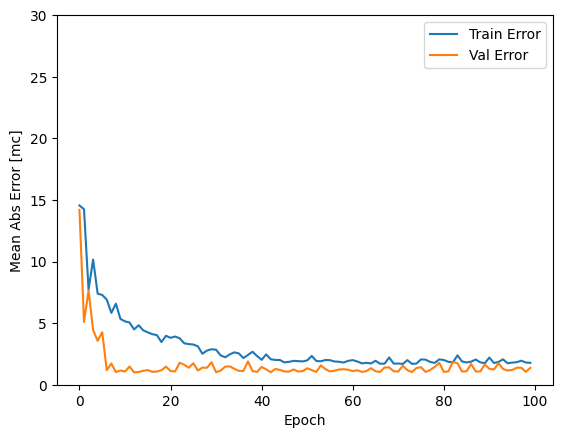

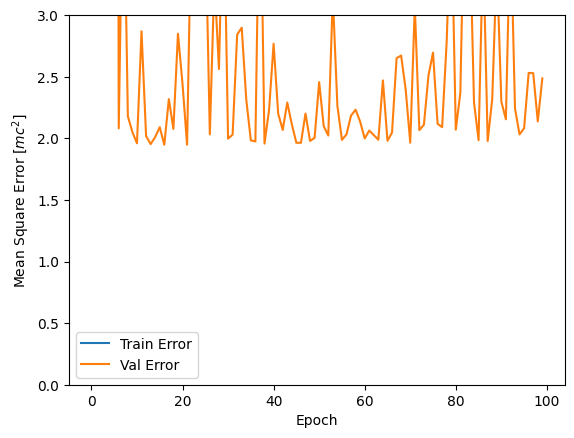

In [12]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mc]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$mc^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

1/1 [==============================] - 0s 23ms/step


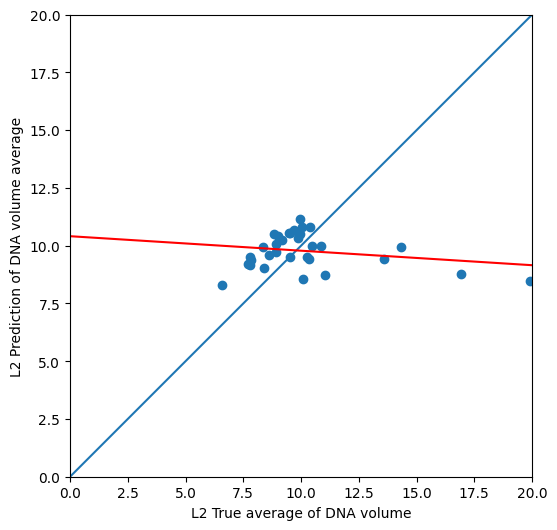

In [13]:
test_predictions = model.predict(x_test).flatten()
res = linregress(y_test, test_predictions)

plt.figure(figsize=(6,6))
plt.scatter(y_test, test_predictions)
# plt.xlabel('True Values [mc]')
# plt.ylabel('Predictions [mc]')
plt.xlabel('L2 True average of DNA volume')
plt.ylabel('L2 Prediction of DNA volume average')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,20])
plt.ylim([0,20])
_ = plt.plot([0,20], [0,20])

plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

# normalizer 学習前

In [14]:
# トレーニングした model をどこかで使用したいなら以下のようにモデルを保存する
model.save('../saved_model/L2_initial')

INFO:tensorflow:Assets written to: ../saved_model/L2_initial/assets


In [15]:
from keras.models import load_model

def getModel(path="../saved_model/L2_ave_230710"):
    model = load_model(path)
    return model


In [16]:
mse = tf.keras.losses.MeanSquaredError()

In [17]:
# model = getModel()
model = getModel('../saved_model/L2_initial')
test_predictions = model.predict(x_test).flatten()

mse(y_test,test_predictions).numpy()

1/1 [==============================] - 0s 33ms/step


8.593822

In [18]:
from keras.models import load_model

def getModel(path="../saved_model/L2_initial"):
    model = load_model(path)
    return model
mse = tf.keras.losses.MeanSquaredError()
model = getModel()
test_predictions = model.predict(x_test).flatten()

mse(y_test,test_predictions).numpy()

1/1 [==============================] - 0s 32ms/step


8.593822

In [19]:
from sklearn.datasets import load_diabetes, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from tensorflow import keras 
import tensorflow as tf
import pandas as pd

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
def randomforest_regressor(x, y, x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(x_train, y_train)
    return regr.score(x_test, y_test)


# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor
def extratrees_regressor(x, y, x_train, x_test, y_train, y_test):
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, random_state=0)
    reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
    x_train, y_train)
    return reg.score(x_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def gradientboosting_regressor(X_train, X_test, y_train, y_test):
    reg = GradientBoostingRegressor(random_state=0)
    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor
def stacking_regressor(X_train, X_test, y_train, y_test):
    X, y = load_diabetes(return_X_y=True)
    estimators = [
        ('lr', RidgeCV()),
        ('svr', LinearSVR(random_state=42))
    ]
    reg = StackingRegressor(
        estimators=estimators,
        final_estimator=RandomForestRegressor(n_estimators=10,
                                            random_state=42)
    )
    ref = reg.fit(X_train, y_train)
    return ref.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor
def voting_regressor(X, y, x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10, random_state=1)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    er.predict(X)
    return er.score(x_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def histgradientboosting_regressor(X, y, x_train, x_test, y_train, y_test):
    # est = HistGradientBoostingRegressor().fit(X, y)
    est = HistGradientBoostingRegressor().fit(x_train, y_train)
    return est.score(x_test, y_test)

def get_model():
    # Create a simple model.
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

def neural_mse(x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_L2_6_model'):
    #y_data = np.concatenate([np.array(y_train),np.array(y_test)])
    #print(type(y_data), y_data.shape)
    #min_val = y_data.min()
    #max_val = y_data.max()
    #y_train = (y_train - min_val)/(max_val - min_val)
    #y_test = (y_test - min_val)/(max_val - min_val)
    #x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()
    for i in range(len(y_test)):
        print(f"Expected {y_test[i]} and got {test_predictions[i]}")

    #mse = tf.keras.losses.MeanSquaredError()
    u = ((y_test-test_predictions)**2).sum()
    v = ((y_test - y_test.mean()) ** 2).sum()

    return 1.0 - u/v #mse(y_test,test_predictions).numpy()

def new_neural_mse(x, y, x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_L2_6_model'):

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()

    mse = tf.keras.losses.MeanSquaredError()

    return mse(y_test,test_predictions).numpy()


In [21]:
x = x_data
y = y_data

extratrees = extratrees_regressor(x, y, x_train, x_test, y_train, y_test)
randomforest = randomforest_regressor(x, y, x_train, x_test, y_train, y_test) 
gradientboosting = gradientboosting_regressor(x_train, x_test, y_train, y_test)
stacking = stacking_regressor(x_train, x_test, y_train, y_test)
voting = voting_regressor(x, y, x_train, x_test, y_train, y_test)
histgradientboosting = histgradientboosting_regressor(x, y, x_train, x_test, y_train, y_test)
neural_mse_score = neural_mse(x_train, x_test, y_train, y_test, model_path='../../script/saved_model/L2_initial')


/Users/hyakuzukamaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/opt/anaconda3/lib/p

AttributeError: 'NoneType' object has no attribute 'split'

In [22]:
lst = []
lst.append(["extratrees" ,extratrees])
lst.append(["randomforest", randomforest])
lst.append(["gradientboosting", gradientboosting])
lst.append(["stacking", stacking])
lst.append(["voting", voting])
lst.append(["histgradientboosting", histgradientboosting])
lst.append(["neural network", neural_mse_score])
    
df = pd.DataFrame(data=lst,columns=['regressor', 'score'])
print(df)



NameError: name 'voting' is not defined

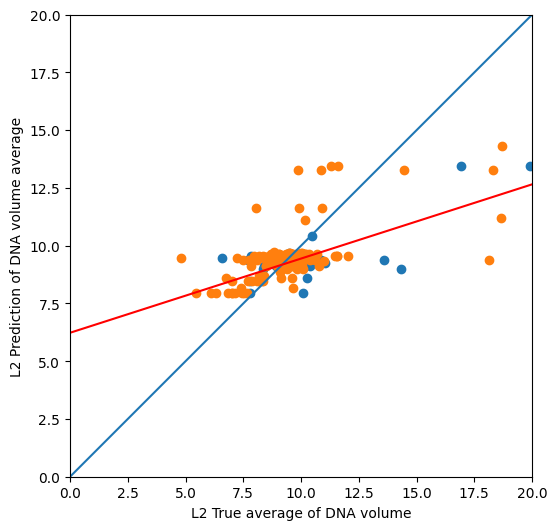

In [23]:
def randomforest_regressor(x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2,n_estimators=10)
    regr.fit(x_train, y_train)

    test_predictions = regr.predict(x_test).flatten()
    train_predictions = regr.predict(x_train).flatten()
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L2 True average of DNA volume')
    plt.ylabel('L2 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

        # Save the model
    with open('../saved_model/randomforest_model_L2.pkl', 'wb') as f:
        pickle.dump(regr, f)
randomforest_regressor(x_train, x_test, y_train, y_test)

In [24]:
def voting_regressor(x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L2 True average of DNA volume')
    plt.ylabel('L2 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

        # Save the model
    #with open('../saved_model/randomforest_model_L2.pkl', 'wb') as f:
    #    pickle.dump(regr, f)
voting_regressor(x_train, x_test, y_train, y_test)

AttributeError: 'NoneType' object has no attribute 'split'

In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

def bagging_regressor(x_train,x_test,y_train,y_test):
    X = x_train
    y = y_train
    er = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=10),n_estimators=10)
    er = er.fit(X, y)

            # Save the model
    with open('../saved_model/bagging_model_L2_initial.pkl', 'wb') as f:
        pickle.dump(er, f)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_train, train_predictions)
    plt.scatter(y_test, test_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L2 True average of DNA volume')
    plt.ylabel('L2 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    print(er.score(x_test, y_test))

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

0.41571280803693056


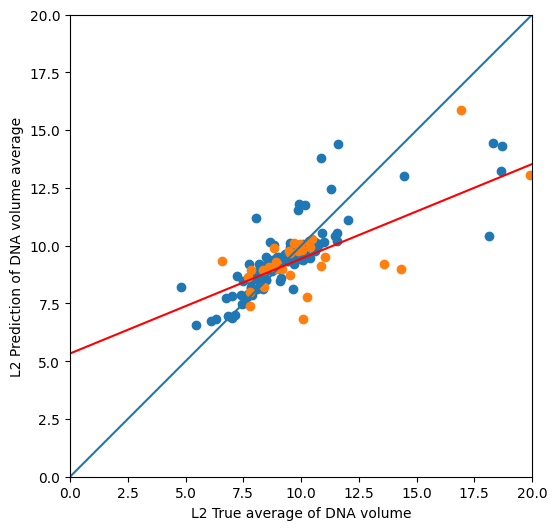

In [28]:
bagging_regressor(x_train, x_test, y_train, y_test)